## MA755 - Assigment 1 - Predict The average annual total cost of attendance 

by Ignacio Carracedo and


## SUMMARY

This notebook builts a model that predicts the average annual total cost of attendance for institutions primarily following an academic year-based calendar system. The average annual cost of attendance includes tuition and fees, books and supplies, and living expenses for all full-time, first-time, degree-/certificate-seeking undergraduates who receive Title IV aid.

We would like to what features such as the institution's location, dregrees offered, size, its students' demography, etc, have more influence in the attendance cost. In addition, we explore how to predict the cost. 

Prelude: Show the Py notebook running enviroment and versions of the libraries we are working with.

In [1]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn

2017-02-11 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [2]:
# Import all the libraries and packages used
import os
from os import listdir
from os.path import isfile, join
import zipfile
from six.moves import urllib

import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline

I. Download the data
The college data set can be downloaded from 'https://collegescorecard.ed.gov/data/'. Data is compress in a zip file that has a .csv file per school year. 

In [ ]:
# Point to the location of the data which will be downloaded
DOWNLOAD_ROOT = "https://ed-public-download.apps.cloud.gov/downloads/"
COLLEGE_PATH = "datasets/collegescorecard"
COLLEGE_URL = DOWNLOAD_ROOT+ "/CollegeScorecard_Raw_Data.zip"

The following funtion will:
* Download dataset into datasets\collegescorecard\CollegeScorecard_Raw_Data folder.
* Extract zip file

In [4]:
def fetch_housing_data(college_url=COLLEGE_URL, college_path=COLLEGE_PATH):
    os.makedirs(college_path, exist_ok=True)
    zip_path = os.path.join(college_path, "CollegeScorecard_Raw_Data.zip")
    urllib.request.urlretrieve(college_url, zip_path)
    college_zip = zipfile.ZipFile(zip_path, 'r')
    college_zip.extractall(path=college_path)
    college_zip.close()

In [ ]:
fetch_housing_data()

There is one csv file for each year, so we need to read the .csv files separatly and concatenate them to one data frame. During this process a YEAR column is added to show the school year of each observation. Because of memory issue, the following function selects a subset of the files, the ones for 2010 and after. 

In [3]:
def load_college_data(college_path=COLLEGE_PATH+'/CollegeScorecard_Raw_Data', string_include = "210" ):
    college_list = []
    
    onlyfiles = [f for f in listdir(college_path) if (isfile(join(college_path, f)))
                 and (".csv" in f) and (string_include in f)]
    
    for f in onlyfiles:
        print("Reading %s ..." %f)
        csv_path = os.path.join(college_path, f)
        aux = pd.read_csv(csv_path,low_memory=False)
        aux['YEAR']=int(f.split('MERGED')[1].split('_')[0])
        college_list.append(aux)
        del aux 
    print("Concatenating files ...")    
    return pd.concat(college_list)

In [4]:
#get a list of files in directory that are .csv in and after 2010 (memory issues)
college = load_college_data(string_include="201")

Reading MERGED2010_11_PP.csv ...
Reading MERGED2011_12_PP.csv ...
Reading MERGED2012_13_PP.csv ...
Reading MERGED2013_14_PP.csv ...
Reading MERGED2014_15_PP.csv ...
Concatenating files ...


Now we have one data frame with all the data. We save the dataframe so we don't have to repeat this process again. This will allow us to start this notebook from this cell if we uncomment the read_csv line:

In [7]:
# Write the data from 2010-2015 to a csv file at the COLLEGE_PATH
college.to_csv(COLLEGE_PATH+'/college.csv',index=False) 

In [ ]:
# read the data back in
college = pd.read_csv(COLLEGE_PATH+'/college.csv', encoding = "ISO-8859-1")

We can now check the size of the data frame and explore the first 5 columns to get a general idea of what it looks like

In [7]:
print("Rows: %s, Columns: %s " %(college.shape[0],college.shape[1]))
college.head()

Rows: 38389, Columns: 1744 


,ï»¿UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM,YEAR
0,100654,00100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0,2010
1,100663,00105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0,2010
2,100690,02503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0,2010
3,100706,00105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0,2010
4,100724,00100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0,2010


Check the non-missing average annual cost change over the 5 years using box plots. 

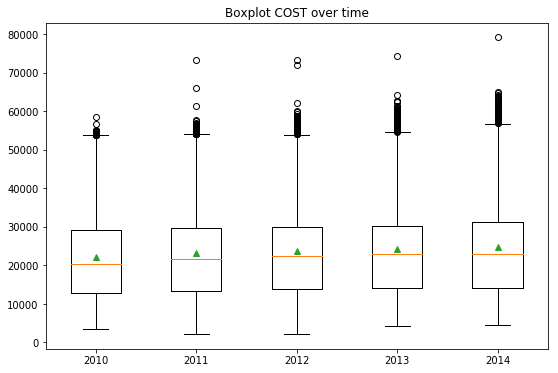

In [16]:
year_cost_data = []

for y in college.YEAR.unique():
    year_cost_data.append(college[college['YEAR']==y]["COSTT4_A"].dropna(axis=0))
    
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
ax.boxplot(year_cost_data, showmeans=True)
plt.title("Boxplot COST over time")
plt.xticks(range(1,6),list(college.YEAR.unique()))
plt.show()

The mean and percentiles (0, 25, 50, 75, 100) of the annual average cost all increased in the 2014-2015 school year compared to 2010-2011 school year. Therefore, we are going to use the data from 2014-2015 school year since it is the most up todate and do not consider prior year's information.
a data frame containing 2014-2015 school year information is created below.

In [8]:
college2014 = college[college['YEAR']==2014] #filer
college2014.to_csv(COLLEGE_PATH+'/college2014.csv',index=False) # save
del college # delete to save memory

Next time we run the notebook we could started using the following cell that loads the data of 2014 back in. It will be faster.

In [9]:
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv', encoding = "ISO-8859-1",low_memory=False)

II Data Exploration
1. Investigate missing values. 
Next cell defines a funtion to return the data frame with all the columns that have a percentage of missing values below a threashold. We will use this funtion to select feautures to feed into our machine learning algorithm because the features with fewer missing values are likely more important.

Since the annual average cost COSTT4_A is the target variable so we select the subset where COSTT4_A is not missing

In [10]:
college2014.dropna(axis=0, subset=["COSTT4_A"], inplace=True)
print("Rows: %s, Columns: %s " %(college2014.shape[0],college2014.shape[1]))

Rows: 4030, Columns: 1744 


We end up with 4030 observations after dropping any missing values for the annual average cost. 

In [12]:
def cols_few_missing_values(df, threshold=0):
    
    '''this function takes a DataFrame and a threshold as parameters and 
       returns the DataFrame with the columns that have a percentage of
       missing values equal or less than the threshold'''

    columns = []
    total_columns = college2014.shape[1]
    missing_values = dict(college2014.isnull().sum())
    
    for key, value in missing_values.items():
        if (value/total_rows) <= threshold:
            columns.append(key)    
            
    df = df[columns]
    print("Keeping %s out of %s columns." %(len(columns), total_columns))
    return (df)

Using the missing value funtion we constructed above we can check which columns have few missng values. we set the theashold of missing values to 10% and reduced the features to 326. 

In [74]:
for i in (np.sort(cols_few_missing_values(college2014,0.1).columns)):
    print(i)

Keeping 326 out of 4030 columns.
?UNITID
AANAPII
AGE_ENTRY
ANNHI
APPL_SCH_N
APPL_SCH_PCT_GE2
APPL_SCH_PCT_GE3
APPL_SCH_PCT_GE4
APPL_SCH_PCT_GE5
CCBASIC
CCSIZSET
CCUGPROF
CIP01ASSOC
CIP01BACHL
CIP01CERT1
CIP01CERT2
CIP01CERT4
CIP03ASSOC
CIP03BACHL
CIP03CERT1
CIP03CERT2
CIP03CERT4
CIP04ASSOC
CIP04BACHL
CIP04CERT1
CIP04CERT2
CIP04CERT4
CIP05ASSOC
CIP05BACHL
CIP05CERT1
CIP05CERT2
CIP05CERT4
CIP09ASSOC
CIP09BACHL
CIP09CERT1
CIP09CERT2
CIP09CERT4
CIP10ASSOC
CIP10BACHL
CIP10CERT1
CIP10CERT2
CIP10CERT4
CIP11ASSOC
CIP11BACHL
CIP11CERT1
CIP11CERT2
CIP11CERT4
CIP12ASSOC
CIP12BACHL
CIP12CERT1
CIP12CERT2
CIP12CERT4
CIP13ASSOC
CIP13BACHL
CIP13CERT1
CIP13CERT2
CIP13CERT4
CIP14ASSOC
CIP14BACHL
CIP14CERT1
CIP14CERT2
CIP14CERT4
CIP15ASSOC
CIP15BACHL
CIP15CERT1
CIP15CERT2
CIP15CERT4
CIP16ASSOC
CIP16BACHL
CIP16CERT1
CIP16CERT2
CIP16CERT4
CIP19ASSOC
CIP19BACHL
CIP19CERT1
CIP19CERT2
CIP19CERT4
CIP22ASSOC
CIP22BACHL
CIP22CERT1
CIP22CERT2
CIP22CERT4
CIP23ASSOC
CIP23BACHL
CIP23CERT1
CIP23CERT2
CIP23CERT4
CIP24

Then we went through the features, further reduced the features using the common knowlege regarding which factors might affect college attendance cost.

We selected the following 77 feaures to model:

* CONTROL:  Public, Private nonprofit, Private for-profit
* MAIN: Flag for main campus
* REGION: REGION
* ICLEVEL: institutional_characteristics.level 4-year,2-year,Less-than-2-year
* NUMBRANCH: Number of branch campuses
* PREDDEG: "Predominant undergraduate degree awarded 0 Not classified 1 Predominantly certificate-degree granting 2  Predominantlyassociate's-degree granting 3 Predominantly bachelor's-degree granting 4 Entirely graduate-degree granting"
* HIGHDEG: "Highest degree awarded 0 Non-degree-granting 1 Certificate degree 2 Associate degree 3 Bachelor's degree 4 Graduate degree"
* PBI: Flag for predominantly black institution
* MENONLY
* WOMENONLY
* PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09", "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22", "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38", "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47", "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54" : types of degrees offered.
* UGDS_2MOR
* UGDS_AIAN
* UGDS_ASIAN
* UGDS_BLACK
* UGDS_HISP
* UGDS_MEN
* UGDS_NHPI
* UGDS_NRA
* UGDS_UNKN
* UGDS_WHITE
* UGDS_WOMEN
* UG: Enrollment of all undergraduate students
* UGDS: Enrollment of undergraduate certificate/degree-seeking students


In [14]:
# feature selection
columns = ['COSTT4_A','CONTROL', 'MAIN', 'REGION', 'ICLEVEL', 'NUMBRANCH','PREDDEG','HIGHDEG',
           'MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05", "PCIP09",
           "PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15", "PCIP16", "PCIP19", "PCIP22",
           "PCIP23", "PCIP24", "PCIP25", "PCIP26", "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38",
           "PCIP39", "PCIP40", "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
           "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE",
           "UGDS_WOMEN", "UGDS"]

college2014 = college2014[columns]

In [48]:
#check categorical data REGION
college2014.REGION.value_counts().sort_values().head(10)

0.0       1
9.0     107
7.0     150
1.0     234
6.0     349
4.0     414
8.0     499
3.0     598
2.0     633
5.0    1045
Name: REGION, dtype: int64

We found that there is one school at region 0. Thus we remove this one record from analysis.

Before modeling, we will split the dataset into a traning set that we will use to train our model and a test set to test the goodness of the model, which we will set aside for final model testing.

Since CONTROL, whether a college is public or private, has a lot of impact on the annual attendance cost, we split the data stratified by CONTROL.

In [16]:
def split(X):
    '''this function takes the college dataframe as  aparameters and 
       returns train/test sets as a tuple. Stritified based on state'''

    # region to same number for stratified split
    X = X[X["REGION"] != 0]
    #stratified split based on states
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    #split
    for train_index, test_index in split.split(X, X["CONTROL"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

train_set, test_set = split(college2014)

In [20]:
train_set.CONTROL.value_counts()/train_set.shape[0]

1    0.401675
2    0.346464
3    0.251861
Name: CONTROL, dtype: float64

In [21]:
test_set.CONTROL.value_counts()/test_set.shape[0]

1    0.401985
2    0.346154
3    0.251861
Name: CONTROL, dtype: float64

Now we can check the historgram for each numeric feature. Most of our features are categorical and are encoded using an integer so the historgrams are not really helpful but it gives us a general idea of the data we are working with. 
We could try to use log transformation for the cost to make it more normally distributed. However, we are not going to do it for this version of analysis.

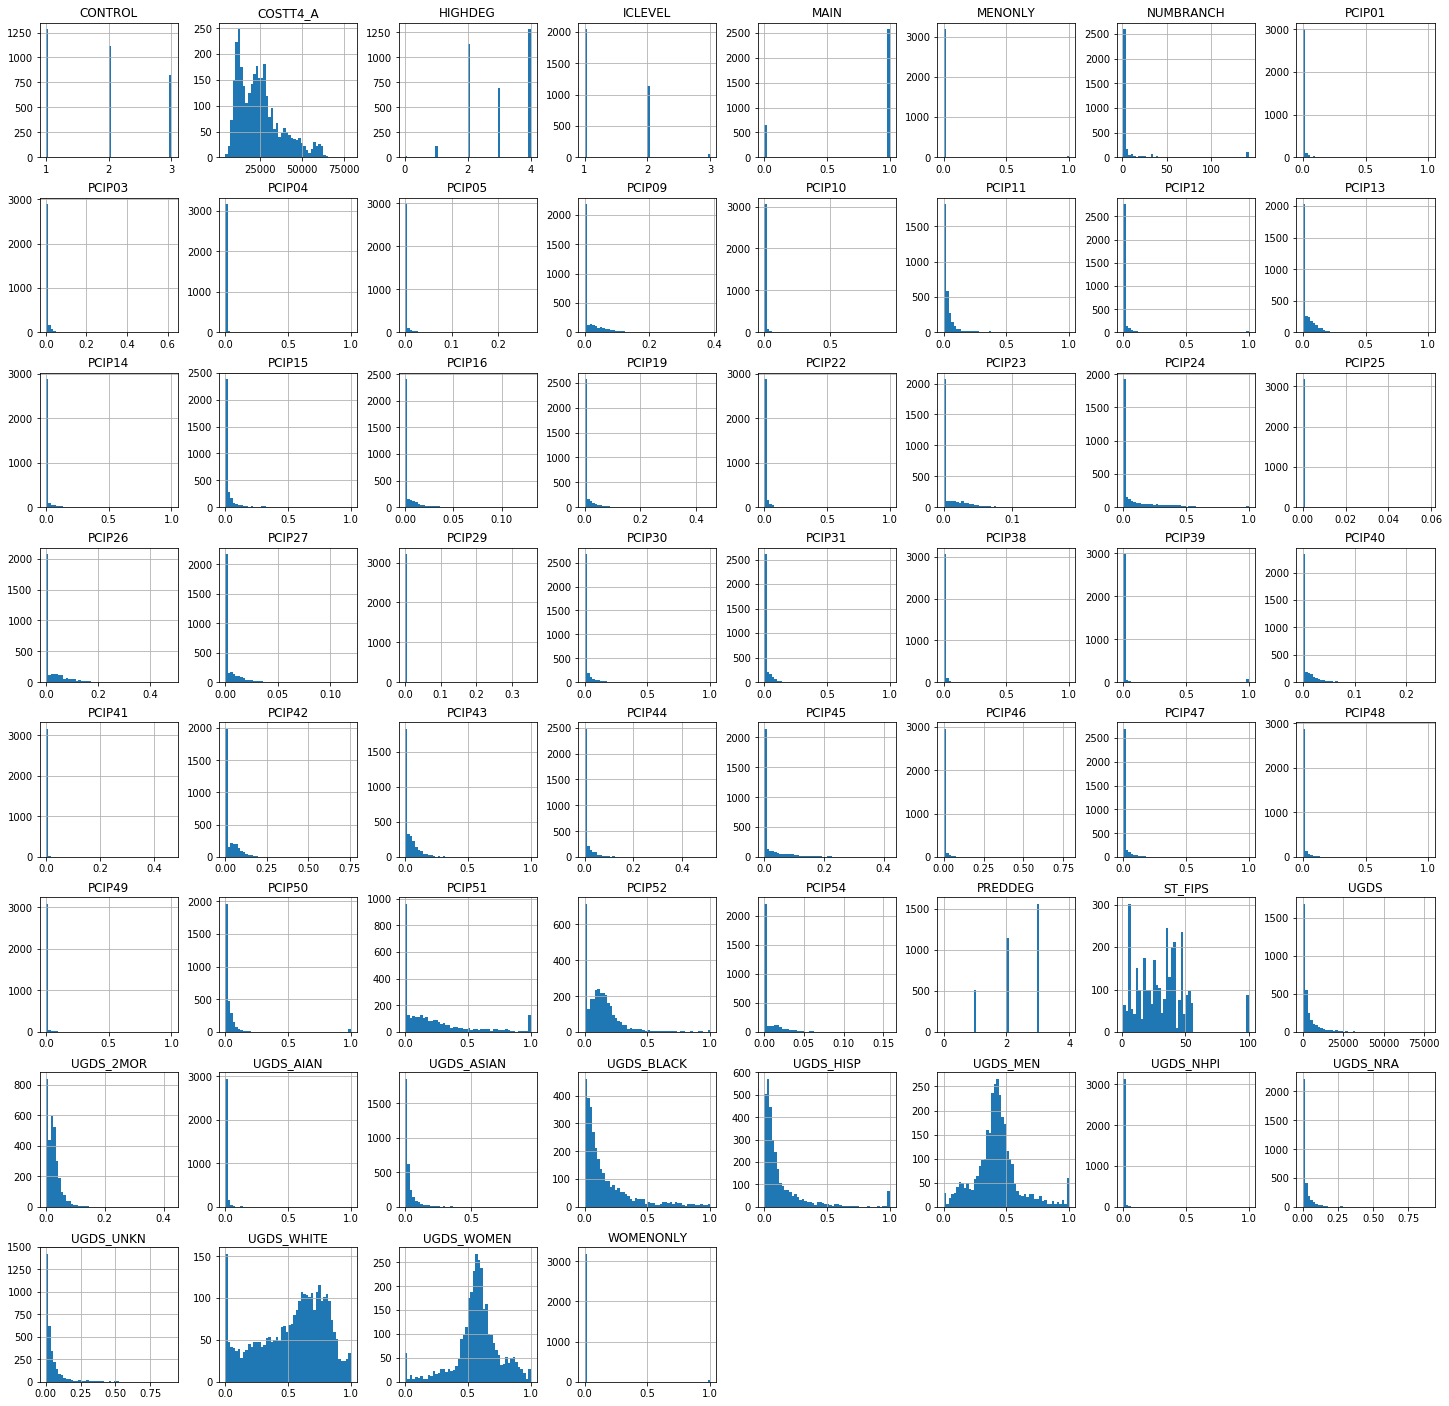

In [14]:
train_set.hist(bins=50, figsize=(25,25))
plt.show()

Let's see how the the target variable histogram looks like

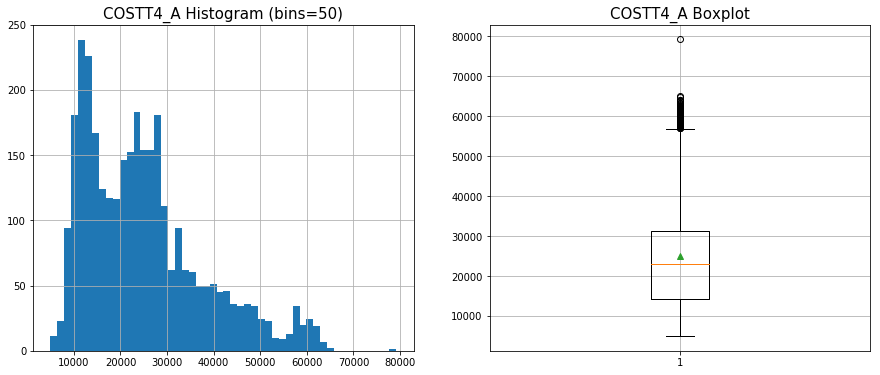

In [23]:
fig = plt.figure(figsize=(15,6))

#hist
ax1 = fig.add_subplot(121)
ax1.hist(train_set.COSTT4_A,bins=50)
ax1.grid(True)
plt.title("COSTT4_A Histogram (bins=50)", size=15)

#boxplot
ax2 = fig.add_subplot(122)
ax2.boxplot(train_set.COSTT4_A, showmeans=True)
ax2.grid(True)
plt.title("COSTT4_A Boxplot",  size=15)
plt.show()

Check scatter plots looking fo interesting patters

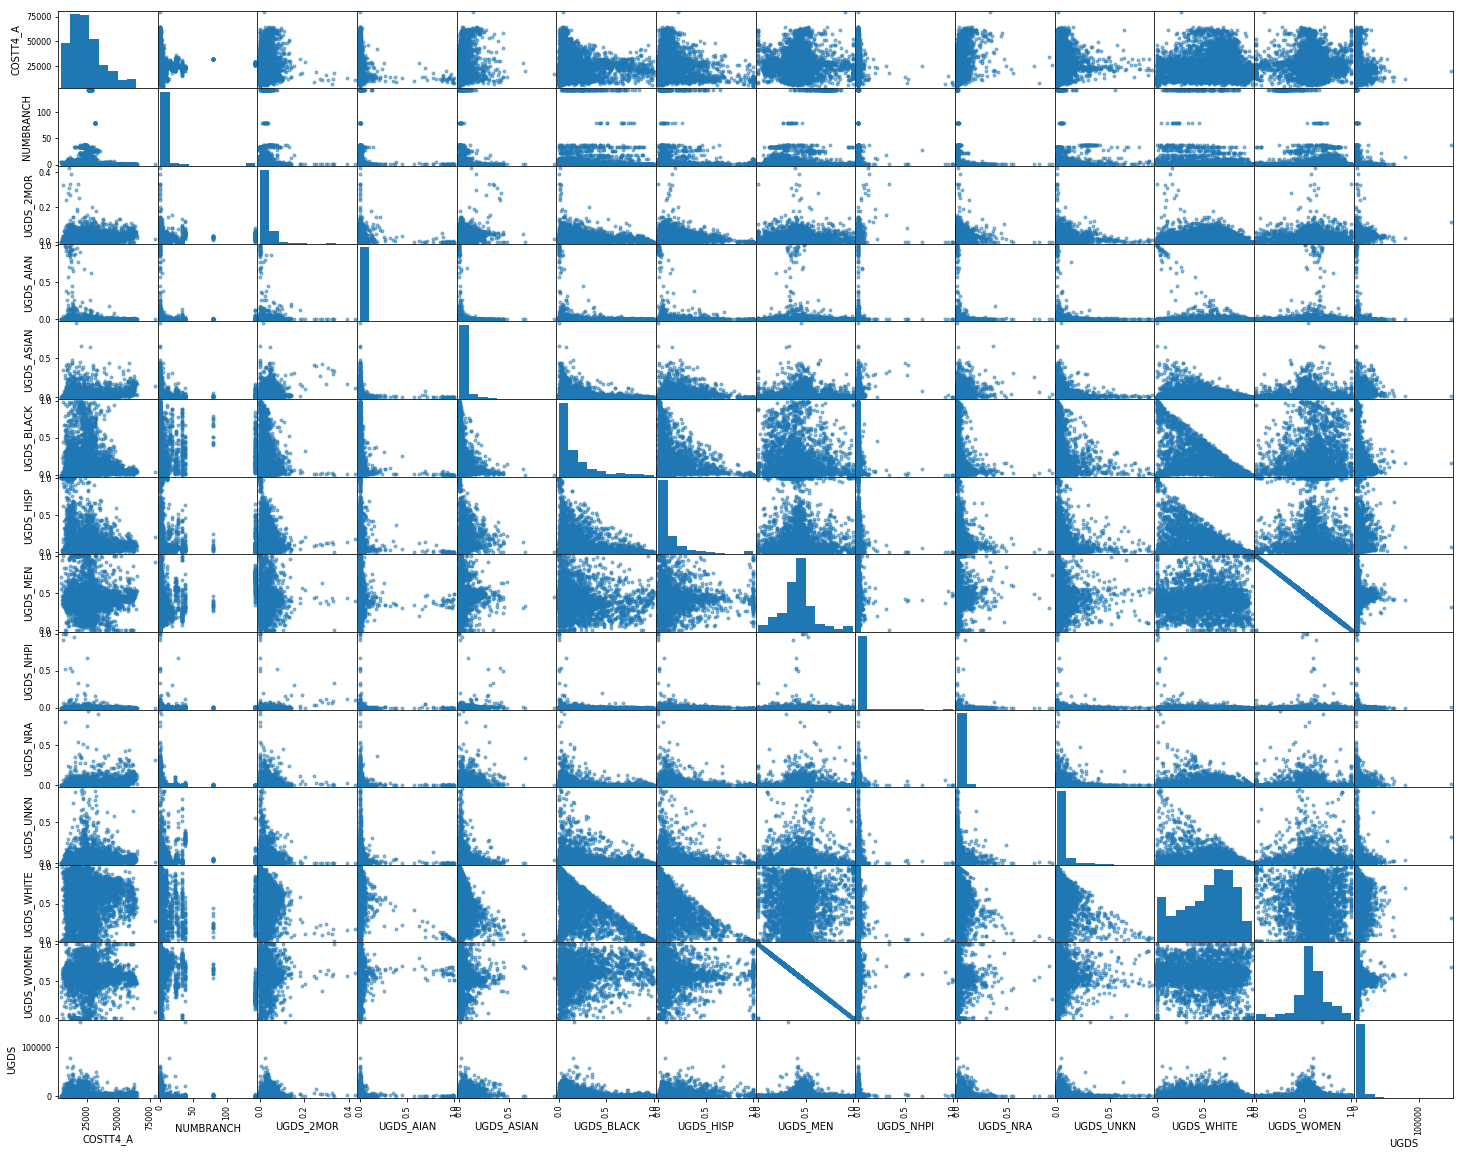

In [10]:
from pandas.tools.plotting import scatter_matrix

attributes = ["COSTT4_A", "NUMBRANCH","UGDS_2MOR", "UGDS_AIAN", "UGDS_ASIAN",
              "UGDS_BLACK", "UGDS_HISP", "UGDS_MEN", "UGDS_NHPI", "UGDS_NRA",
              "UGDS_UNKN", "UGDS_WHITE", "UGDS_WOMEN","UGDS"]

scatter_matrix(train_set[attributes], figsize=(25, 20), alpha=0.5)
plt.show()

Not much correlation but at least we can see we don't need both UGDS woman and man. They look complementary, let's double check

In [15]:
train_set[["UGDS_MEN","UGDS_WOMEN"]].head()

,UGDS_MEN,UGDS_WOMEN
4647,0.3415,0.6585
6579,0.0000,1.0000
1755,0.6021,0.3979
5591,0.0857,0.9143
1674,0.9029,0.0971


Lets check how many missing values we have (many different ways of doing it):

In [34]:
train_set.drop("UGDS_WOMEN", 1, inplace=True)

let's check correlation

In [19]:
corr_matrix = train_set.corr()
corr_matrix["COSTT4_A"].sort_values(ascending=False)[:20]

COSTT4_A      1.000000
HIGHDEG       0.482828
PREDDEG       0.457039
PCIP23        0.441742
PCIP26        0.439033
PCIP45        0.429653
CONTROL       0.415113
PCIP54        0.414856
PCIP27        0.391832
PCIP40        0.340300
PCIP16        0.335022
UGDS_NRA      0.324657
PCIP09        0.287758
PCIP42        0.282003
PCIP50        0.259551
PCIP05        0.188675
PCIP14        0.163201
WOMENONLY     0.155984
UGDS_ASIAN    0.147166
UGDS_UNKN     0.117831
Name: COSTT4_A, dtype: float64

In [ ]:
corr_matrix

Let check missing values

In [24]:
print("Number of featues with at least 1 missing value: %s"
      %(train_set.isnull().sum() != 0).sum())

Number of featues with at least 1 missing value: 0


We don't have missing values!!!!!!!!!!!! nice!

We now know all the neccesary steps we need to take to get the data ready for a machine learning models. To simplify building models we are going to create a pipeline that will get the original data and will output the data we'll feed to our models.

For the pipeline to work we need to create custom tranfomres. These classes will have the same structuture as skilearn tranformers, that means all will have the funtions fit, tranform, and fit_tranform (this one will be inherit from TransformerMixin). BaseEstimator will provide the implementation of get_params and set_params(\*\*params).

We'll define to custom tranformers:

* one_hot:
* transform:

and one function:

* split:

### Custom transformers

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

class one_hot(BaseEstimator, TransformerMixin):
    
    def __init__(self): 
        self.control_encoder = OneHotEncoder(sparse=False)
        self.iclever_encoder = OneHotEncoder(sparse=False)
        self.region_encoder = OneHotEncoder(sparse=False)
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        
        X.reset_index(drop=True,inplace=True)
                
        CONTROL = self.control_encoder.fit_transform(X["CONTROL"].reshape(-1, 1))
        control_df = pd.DataFrame(CONTROL,
                                  columns=["CONTROL1","CONTROL2","CONTROL3"]).reset_index(drop=True)
        X = pd.concat([X, control_df], axis=1)
        X.drop("CONTROL",axis=1,inplace=True)
                
        ICLEVEL = self.iclever_encoder.fit_transform(X["ICLEVEL"].reshape(-1, 1))
        iclevel_df = pd.DataFrame(ICLEVEL,
                                  columns=["ICLEVEL1","ICLEVEL2","ICLEVEL3"]).reset_index(drop=True)
        X = pd.concat([X, iclevel_df], axis=1)
        X.drop("ICLEVEL",axis=1,inplace=True)
        
        
        REGION = self.region_encoder.fit_transform(X["REGION"].reshape(-1, 1))
        region_df = pd.DataFrame(REGION).reset_index(drop=True)
        X = pd.concat([X, region_df], axis=1)
        X.drop("REGION",axis=1,inplace=True)

        return X

    
class feature_selection(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        return X[self.attribute_names]

    
def split(X):
    '''this function takes the college dataframe as  aparameters and 
       returns train/test sets as a tuple. Stritified based on state'''

    # region to same number for stratified split
    X = X[X["REGION"] != 0]
    #stratified split based on states
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)
    #split
    for train_index, test_index in split.split(X, X["CONTROL"]):
        train_set = X.iloc[train_index]
        test_set = X.iloc[test_index]

    return(train_set,test_set)

train_set, test_set = split(college2014)

## PIPELINE

Now that we have define our tranformers we can run our pipeline to get the proccess data. The pipeline will use the fit_transform method of each tranformer and pass the output to the next step of the pipeline. Once that is done we can apply the split funtion to get our train and test set. 

In [56]:
# load data
college2014 = pd.read_csv(COLLEGE_PATH+'/college2014.csv',
                          encoding = "ISO-8859-1",low_memory=False)
college2014.dropna(axis=0, subset=["COSTT4_A"], inplace=True)

#columns to keep
columns = ['COSTT4_A','CONTROL', 'MAIN', 'REGION', 'ICLEVEL', 'NUMBRANCH','PREDDEG',
           'HIGHDEG','MENONLY','WOMENONLY',"PCIP01", "PCIP03","PCIP04", "PCIP05",
           "PCIP09","PCIP10", "PCIP11", "PCIP12", "PCIP13", "PCIP14", "PCIP15",
           "PCIP16", "PCIP19", "PCIP22","PCIP23", "PCIP24", "PCIP25", "PCIP26",
           "PCIP27", "PCIP29", "PCIP30", "PCIP31", "PCIP38","PCIP39", "PCIP40",
           "PCIP41", "PCIP42", "PCIP43", "PCIP44", "PCIP45", "PCIP46", "PCIP47",
           "PCIP48", "PCIP49", "PCIP50", "PCIP51", "PCIP52", "PCIP54", "UGDS_2MOR",
           "UGDS_AIAN", "UGDS_ASIAN","UGDS_BLACK", "UGDS_HISP", "UGDS_MEN",
           "UGDS_NHPI", "UGDS_NRA", "UGDS_UNKN", "UGDS_WHITE", "UGDS"]

#pipeline
college_pipeline = Pipeline([
        ('feature_selection', feature_selection(columns)),
        ('one_hot', one_hot()),
        #('std_scaler', StandardScaler()),
    ])

# run pipeline
train_set, test_set = split(college2014)
train_set = college_pipeline.fit_transform(train_set)
test_set = college_pipeline.fit_transform(test_set)

# check sets size
print("TRAIN SET rows: %s, columns: %s " %(train_set.shape[0],train_set.shape[1]))
print("TEST SET rows: %s, columns: %s " %(test_set.shape[0],test_set.shape[1]))

TRAIN SET rows: 3223, columns: 71 
TEST SET rows: 806, columns: 71 


## MODEL

In [58]:
X_train = train_set.drop("COSTT4_A", axis=1)
y_train = train_set["COSTT4_A"]
X_test = test_set.drop("COSTT4_A", axis=1)
y_test = test_set["COSTT4_A"]

In [59]:
y_train.describe()

count     3223.000000
mean     24889.329817
std      12783.917486
min       4974.000000
25%      14192.500000
50%      22965.000000
75%      31308.000000
max      79212.000000
Name: COSTT4_A, dtype: float64

Scikit-Learn cross-validation features expect a utility function
(greater is better) rather than a cost function (lower is better), so
the scoring function is actually the opposite of the MSE (ie. a negative
value), which is why the code above computes -scores before
calculating the square root.

## SELECT MODEL

In [31]:
tree_reg = DecisionTreeRegressor()

tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 6367.15369235  6625.16925756  5960.64912106  7508.89106039  6621.37402894
  6643.9028678   7460.33161095  7307.29678757  6648.92757756  8032.61119376
  5609.76430734  6675.39156923  6133.37755177  6717.94826524  6698.64943466
  6250.70973759  7120.49211652  7899.02990624  6542.6932637   5994.23789622]
Mean: 6740.93006232
Standard deviation: 627.229099876


In [32]:
lin_reg = LinearRegression()

tree_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 5622.88512971  6413.62772198  5018.82685976  5833.0538468   5510.13563091
  5287.25729598  5632.18293187  7060.71421905  5577.31058806  6074.6683244
  5771.80433415  6915.60145174  6136.49002926  6187.7685083   5613.30065674
  5671.34444558  5737.21467322  6132.74225     6455.02049094  4844.82147838]
Mean: 5874.83854334
Standard deviation: 548.323665634


In [33]:
forest_reg = RandomForestRegressor()

tree_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 4917.1823171   5428.16020012  4237.89501975  4597.72275321  4602.79331323
  4754.27506493  4823.09748651  5751.09898432  4600.0951404   4873.29818584
  4096.62208654  5688.2131009   4731.73186703  5533.21253707  4844.84177061
  4635.64920472  4848.02338019  5829.01270324  5584.93897384  3995.71417368]
Mean: 4918.67891316
Standard deviation: 531.698426608


## TUNE MODEL

In [82]:
param_grid = [{'n_estimators': [750, 1000], 'max_features': [40,"sqrt"],
               'bootstrap': [True,False], 'min_samples_leaf':[1,2]}]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 11.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_leaf': [1, 2], 'bootstrap': [True, False], 'max_features': [40, 'sqrt'], 'n_estimators': [750, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

 ----------------- GRID_SEARCH INFO -----------------
 
{'n_estimators': 1000, 'max_features': 40, 'bootstrap': False, 'min_samples_leaf': 2}
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=40, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best CV score: 4698.67035409
4714.83999915 {'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 40, 'n_estimators': 750}
4702.07035505 {'min_samples_leaf': 1, 'bootstrap': True, 'max_features': 40, 'n_estimators': 1000}
4707.05373316 {'n_estimators': 750, 'max_features': 40, 'bootstrap': True, 'min_samples_leaf': 2}
4706.94123378 {'min_samples_leaf': 2, 'bootstrap': True, 'max_features': 40, 'n_estimators': 1000}
4820.61468068 {'n_estimators': 750, 'max_features': 'sqrt', 'bootstrap': True, 'min_sample

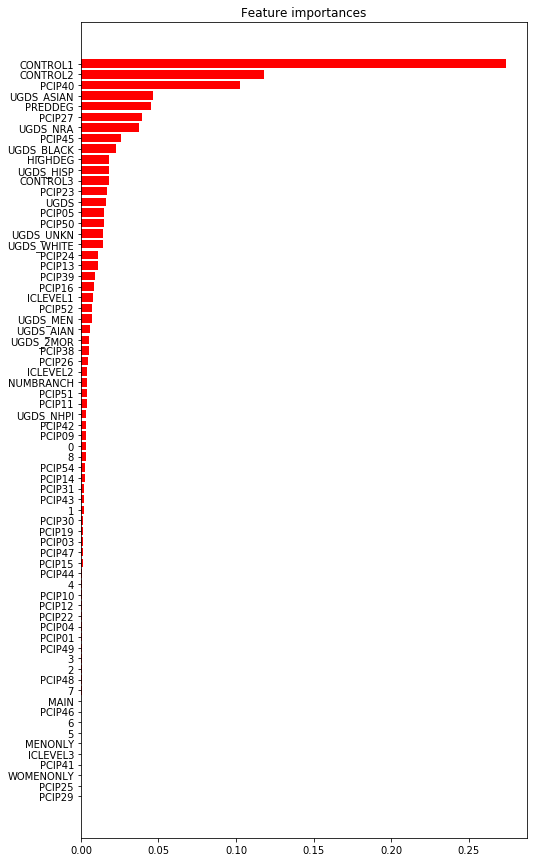

In [83]:
print(" ----------------- GRID_SEARCH INFO -----------------\n ")
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print("Best CV score:", np.sqrt(-grid_search.best_score_))

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

print("\n ----------------- FEATURE IMPORTANCE INFO ----------------- ")    
feature_importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)[::-1]
attributes = X_train.columns

# print feature_importances
fimpotances = sorted(zip(feature_importances, attributes), reverse=True)
for f in fimpotances:
    print(f)

# plot 15 most important features 
plt.figure(figsize=(8, 15))
plt.barh(range(X_train.shape[1]), feature_importances[indices], color="r", align="center")
plt.yticks(range(X_train.shape[1]), [x[1] for x in fimpotances])
plt.title("Feature importances")
plt.gca().invert_yaxis()
plt.show()

## FINAL MODEL

In [84]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 4467.39
final_rmse

4629.7355790905794

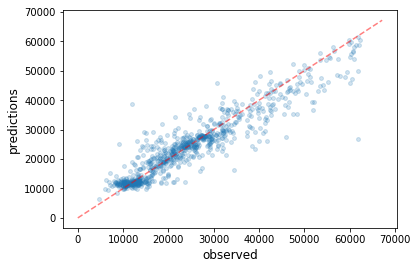

In [85]:
plt.scatter(y_test,final_predictions,alpha=0.2, s=15)
plt.xlabel('observed', fontsize=12)
plt.ylabel('predictions', fontsize=12)
plt.plot([0,(np.max(y_test) + 5000)],[0,(np.max(y_test) + 5000)], 'r--', alpha=0.5)
plt.show()

What else??:
    
* Regression to interpret each coefficient
* Check other features
* Scale and other data tranformation
* Try to get more data
* Group states different way
* Split stratified with a different 

The end